<a href="https://colab.research.google.com/github/Akkki28/VLM/blob/main/RAM_GroundingDINO_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Recognition

In [73]:
import ipywidgets as widgets
from IPython.display import clear_output, display, Image
import os
import requests
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random
import numpy as np
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from transformers import SamModel, SamProcessor
import re
import requests

In [74]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [75]:
!git clone https://github.com/xinyu1205/recognize-anything.git

%cd recognize-anything
!git checkout ec6b4241c5036e337a4543838deb9bff4990de97

Cloning into 'recognize-anything'...
remote: Enumerating objects: 748, done.
remote: Counting objects: 100% (371/371), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 748 (delta 290), reused 207 (delta 206), pack-reused 377 (from 2)
Receiving objects: 100% (748/748), 27.15 MiB | 16.95 MiB/s, done.
Resolving deltas: 100% (397/397), done.
/content/recognize-anything/recognize-anything/recognize-anything
Note: switching to 'ec6b4241c5036e337a4543838deb9bff4990de97'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to

In [76]:
!pip install timm transformers fairscale pycocoevalcap

clear_output()

In [77]:
model_widget = widgets.Dropdown(
    options=["RAM", "Tag2Text"],
    value="Tag2Text",
    description="Select mdoel:"
)
display(model_widget)

Dropdown(description='Select mdoel:', index=1, options=('RAM', 'Tag2Text'), value='Tag2Text')

In [78]:
model = model_widget.value

In [79]:
def download_checkpoints(model):
    print('You selected', model)
    if not os.path.exists('pretrained'):
        os.makedirs('pretrained')

    if model == "RAM":
        ram_weights_path = 'pretrained/ram_swin_large_14m.pth'
        if not os.path.exists(ram_weights_path):
            !wget https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text/resolve/main/ram_swin_large_14m.pth -O pretrained/ram_swin_large_14m.pth
        else:
            print("RAM weights already downloaded!")
    else:
        tag2text_weights_path = 'pretrained/tag2text_swin_14m.pth'
        if not os.path.exists(tag2text_weights_path):
            !wget https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text/resolve/main/tag2text_swin_14m.pth -O pretrained/tag2text_swin_14m.pth
        else:
            print("Tag2Text weights already downloaded!")

download_checkpoints(model)
print(model, 'weights are downloaded!')


You selected Tag2Text
--2025-03-25 13:17:29--  https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text/resolve/main/tag2text_swin_14m.pth
Resolving huggingface.co (huggingface.co)... 13.35.202.121, 13.35.202.97, 13.35.202.40, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.121|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /spaces/xinyu1205/recognize-anything/resolve/main/tag2text_swin_14m.pth [following]
--2025-03-25 13:17:29--  https://huggingface.co/spaces/xinyu1205/recognize-anything/resolve/main/tag2text_swin_14m.pth
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/e6/78/e678f8565485a3f321b1180e4c7e1e18a89a9295028358eedffb98981b37e11a/4ce96f0ce98f940a6680d567f66a38ccc9ca8c4e638e5f5c5c2e881a0e3502ac?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27tag2text_swin_14m.pth%3B+filename%3D%22tag2text_swin_14m.pth%22%3B

In [80]:
task_widget = widgets.Dropdown(
    options=["one image", "multiple images"],
    value="one image",
    description="Task:"
)
display(task_widget)

Dropdown(description='Task:', options=('one image', 'multiple images'), value='one image')

In [81]:
task = task_widget.value

In [82]:
img_path = '/content/fruits2.jpg'

In [83]:
print('You selected', model)
print('You selected', task)

def run_inference(model, task):
    if model == "Tag2Text" and task == "one image":
        !python inference_tag2text.py  --image {img_path} \
        --pretrained pretrained/tag2text_swin_14m.pth > output.txt
    elif model == "RAM" and task == "one image":
        !python inference_ram.py  --image {img_path} \
        --pretrained pretrained/ram_swin_large_14m.pth > output.txt
    else:
        print('Invalid model or task')

run_inference(model, task)

You selected Tag2Text
You selected one image
2025-03-25 13:18:12.657989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742908692.678572    7115 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742908692.685045    7115 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprec

In [84]:
with open("output.txt", "r") as file:
    content = file.read()

match = re.search(r"Model Identified Tags:\s*(.*)", content)

if match:
    tags = match.group(1).split(" | ")
    print(tags)
else:
    print("Tags not found")


['table', 'orange', 'apple', 'fruit', 'sit', 'sit on', 'wooden', 'red', 'some']


# Bounding Boxes

In [85]:
%cd -

/content/recognize-anything/recognize-anything


In [86]:
model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image = Image.open(img_path)

text_labels = [tags]

inputs = processor(images=image, text=text_labels, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)

result = results[0]
for box, score, labels in zip(result["boxes"], result["scores"], result["labels"]):
    box = [round(x, 2) for x in box.tolist()]
    print(f"Detected {labels} with confidence {round(score.item(), 3)} at location {box}")

Detected apple with confidence 0.671 at location [341.08, 113.08, 564.84, 328.84]
Detected apple with confidence 0.605 at location [0.04, 94.05, 116.34, 248.19]
Detected apple with confidence 0.523 at location [78.57, 42.51, 204.9, 171.96]
Detected table with confidence 0.576 at location [-0.08, 0.59, 625.91, 415.46]
Detected apple with confidence 0.494 at location [55.95, 31.87, 131.21, 103.12]
Detected orange with confidence 0.556 at location [214.84, 43.43, 371.31, 177.52]
Detected orange with confidence 0.485 at location [177.12, 0.22, 285.22, 93.48]
Detected orange with confidence 0.45 at location [81.03, 1.84, 175.05, 53.11]


<ipython-input-86-97d182e69c7a>:15: FutureWarning: `box_threshold` is deprecated and will be removed in version 4.51.0 for `GroundingDinoProcessor.post_process_grounded_object_detection`. Use `threshold` instead.
  results = processor.post_process_grounded_object_detection(
/usr/local/lib/python3.11/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:95: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


<ipython-input-87-1272f4dc5cb6>:15: FutureWarning: `box_threshold` is deprecated and will be removed in version 4.51.0 for `GroundingDinoProcessor.post_process_grounded_object_detection`. Use `threshold` instead.
  results = processor.post_process_grounded_object_detection(
/usr/local/lib/python3.11/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:95: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


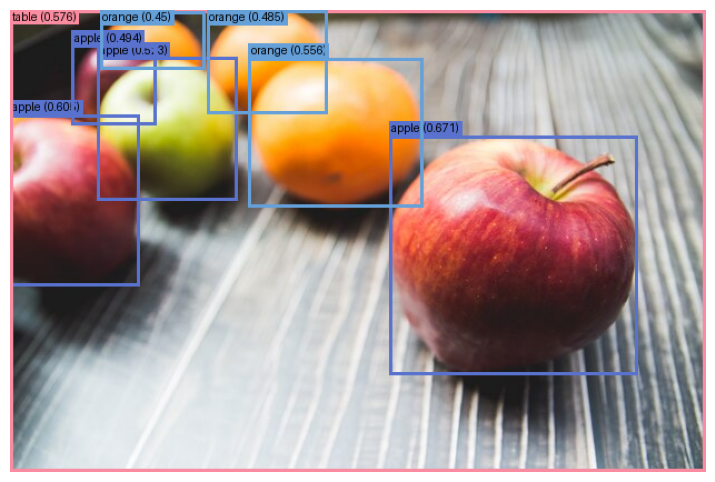

In [87]:
model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image = Image.open(img_path)

text_labels = [tags]

inputs = processor(images=image, text=text_labels, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)

def generate_color(label):
    random.seed(hash(label) % (2**32))
    return tuple(random.randint(50, 255) for _ in range(3))

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

result = results[0]
boxes = result["boxes"]
labels = result["labels"]

label_colors = {}

for box, score, label in zip(result["boxes"], result["scores"], result["labels"]):
    box = [round(x, 2) for x in box.tolist()]
    if label not in label_colors:
        label_colors[label] = generate_color(label)
    color = label_colors[label]

    draw.rectangle(box, outline=color, width=3)

    text = f"{label} ({round(score.item(), 3)})"
    text_size = draw.textbbox((0, 0), text, font=font)
    text_width = text_size[2] - text_size[0]
    text_height = text_size[3] - text_size[1]

    text_x = box[0]
    text_y = max(box[1] - text_height - 2, 0)
    draw.rectangle([text_x, text_y, text_x + text_width + 4, text_y + text_height + 2], fill=color)

    draw.text((text_x + 2, text_y), text, fill="black", font=font)

plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")
plt.show()


In [88]:
%cd -

/content/recognize-anything/recognize-anything/recognize-anything


# Segmentation


Loading SAM model...
Image shape: (416, 626, 3)
Processing masks for 8 detected objects...
Processing object 1/8: apple


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


  Raw mask shape: torch.Size([1, 3, 416, 626])
  Multi-channel mask detected with shape torch.Size([3, 416, 626])
  Processed mask shape: (416, 626)
  Applied mask for apple
Processing object 2/8: apple
  Raw mask shape: torch.Size([1, 3, 416, 626])
  Multi-channel mask detected with shape torch.Size([3, 416, 626])
  Processed mask shape: (416, 626)
  Applied mask for apple
Processing object 3/8: apple
  Raw mask shape: torch.Size([1, 3, 416, 626])
  Multi-channel mask detected with shape torch.Size([3, 416, 626])
  Processed mask shape: (416, 626)
  Applied mask for apple
Processing object 4/8: table
  Raw mask shape: torch.Size([1, 3, 416, 626])
  Multi-channel mask detected with shape torch.Size([3, 416, 626])
  Processed mask shape: (416, 626)
  Applied mask for table
Processing object 5/8: apple
  Raw mask shape: torch.Size([1, 3, 416, 626])
  Multi-channel mask detected with shape torch.Size([3, 416, 626])
  Processed mask shape: (416, 626)
  Applied mask for apple
Processing obj

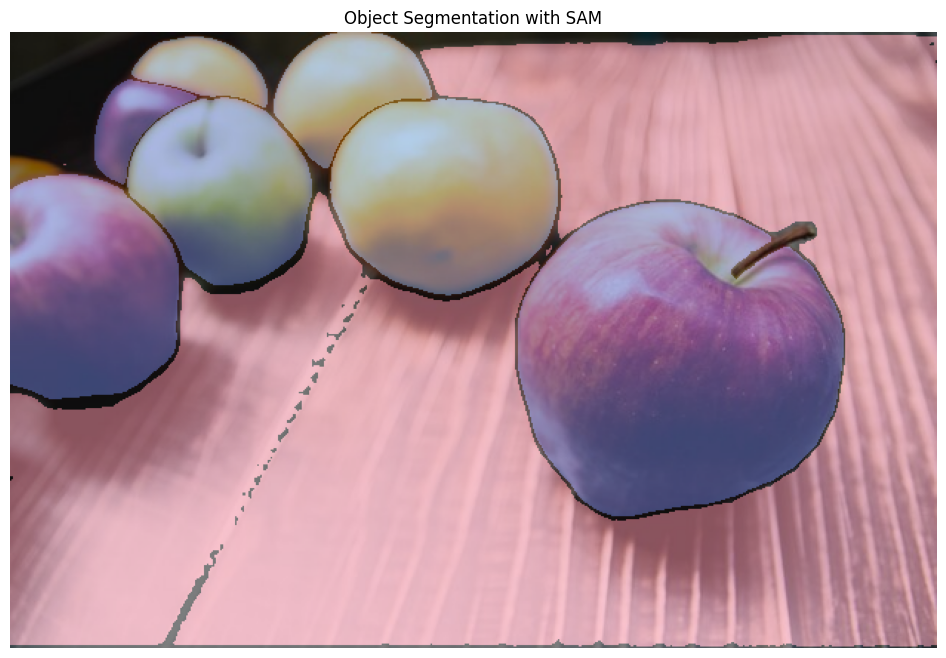

In [89]:
original_image = Image.open(img_path)
print("Loading SAM model...")
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

np_image = np.array(original_image)
height, width, _ = np_image.shape
print(f"Image shape: {np_image.shape}")

combined_mask = np.zeros((height, width), dtype=bool)
colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

print(f"Processing masks for {len(result['boxes'])} detected objects...")

for i, (box, label) in enumerate(zip(result["boxes"], result["labels"])):
    print(f"Processing object {i+1}/{len(result['boxes'])}: {label}")

    box_coords = box.cpu().tolist()

    try:
        inputs = sam_processor(
            original_image,
            input_boxes=torch.tensor([[box_coords]]),
            return_tensors="pt"
        )
        for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
                inputs[k] = v.to(device)

        with torch.no_grad():
            outputs = sam_model(**inputs)

        masks = sam_processor.image_processor.post_process_masks(
            outputs.pred_masks.cpu(),
            inputs["original_sizes"].cpu(),
            inputs["reshaped_input_sizes"].cpu()
        )
        print(f"  Raw mask shape: {masks[0].shape}")

        if masks[0].shape[0] > 0:
            if len(masks[0][0].shape) == 3:
                print(f"  Multi-channel mask detected with shape {masks[0][0].shape}")
                mask = masks[0][0][0].numpy() > 0.0
            else:
                mask = masks[0][0].numpy() > 0.0

            print(f"  Processed mask shape: {mask.shape}")
            if label not in label_colors:
                label_colors[label] = generate_color(label)
            color = np.array(label_colors[label])
            object_mask = ~combined_mask & mask
            colored_mask[object_mask] = color
            combined_mask = combined_mask | mask

            print(f"  Applied mask for {label}")
        else:
            print(f"  No valid mask found for {label}")

    except Exception as e:
        print(f"  Error processing {label}: {str(e)}")
        import traceback
        traceback.print_exc()

alpha = 0.5
mask_overlay = np.zeros_like(np_image)
mask_overlay[combined_mask] = colored_mask[combined_mask]

result_image = (np_image * (1 - alpha) + mask_overlay * alpha).astype(np.uint8)
result_pil = Image.fromarray(result_image)

plt.figure(figsize=(12, 8))
plt.imshow(result_pil)
plt.title("Object Segmentation with SAM")
plt.axis("off")
plt.show()